In [2]:
# Load data pkl file
import pickle5 as pickle
from tqdm import tqdm
import pandas as pd
with open('data/reduced.pkl', 'rb') as f:
    data_dict = pickle.load(f)

# Load guide csv file
df = pd.read_csv('data/LigID_pdbchain_partition.csv')

# Add ion info in dict
print('\nAdding ion info to dict...')
for key in tqdm(data_dict.keys()):
    try:
        data_dict[key].append(df[df['pdb_chain']==key]['LigID'].item())
        data_dict[key].append(df[df['pdb_chain']==key]['partitions'].item())
    except:
        pass
        #print('Problem with %s'%(key))


Adding ion info to dict...


100%|██████████| 28310/28310 [01:14<00:00, 377.95it/s]


In [5]:
import numpy as np
import os
from utils import ProtEmbDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/'
model_name = 'esm1_t34_670M_UR50D'
holdout_batches = []

holdout_fold = 6
for datapoint in os.listdir(data_path+model_name+'_batch128_CV/'):
    if datapoint.endswith('fold%s.pickle'%(holdout_fold)):
        holdout_batches.append(datapoint)
    else:
        pass

data_list = np.array(os.listdir(data_path+model_name+'_batch128_CV/'))

holdout_indices = list(np.where(np.isin(data_list, holdout_batches))[0])

protein_dataset = ProtEmbDataset(model_name)
sampler_holdout = SubsetRandomSampler(holdout_indices)

dataloader_holdout = DataLoader(protein_dataset, batch_size=1, sampler = sampler_holdout, num_workers=4)

In [6]:
len(dataloader_holdout), dataloader_holdout.dataset[0][0].shape

(9, torch.Size([42185, 1280]))

### External validation
Folds 1-5 were used as training (4 for training, 1 for testing) in a 5-fold CV setup. Fold-6 was kept as a holdout set for external validation. Results follow. 

Analysing fold 1...


100%|██████████| 1121/1121 [01:12<00:00, 15.40it/s]


ion, aupr, auroc
CA 0.429 0.838
CO 0.193 0.696
CU 0.81 0.971
FE2 0.845 0.993
FE 0.919 0.995
MG 0.43 0.851
MN 0.748 0.943
PO4 0.231 0.927
SO4 0.17 0.713
ZN 0.677 0.946


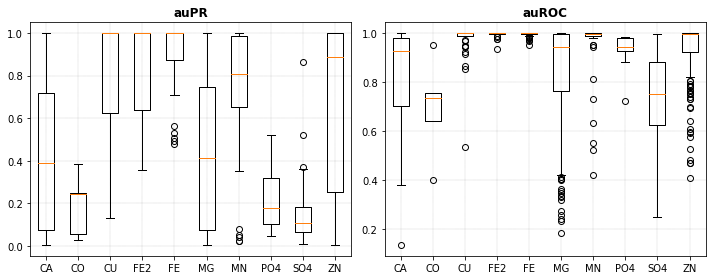

Analysing fold 2...


100%|██████████| 1121/1121 [00:11<00:00, 97.16it/s] 


ion, aupr, auroc
CA 0.412 0.825
CO 0.298 0.741
CU 0.77 0.978
FE2 0.816 0.974
FE 0.937 0.993
MG 0.43 0.854
MN 0.789 0.963
PO4 0.248 0.921
SO4 0.192 0.745
ZN 0.66 0.932


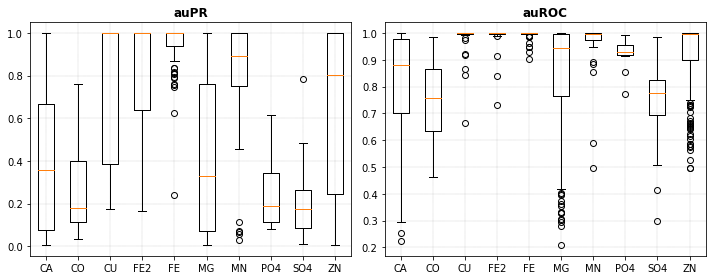

Analysing fold 3...


100%|██████████| 1121/1121 [00:11<00:00, 95.82it/s] 


ion, aupr, auroc
CA 0.412 0.838
CO 0.244 0.748
CU 0.853 0.977
FE2 0.869 0.986
FE 0.92 0.993
MG 0.429 0.858
MN 0.75 0.947
PO4 0.283 0.905
SO4 0.19 0.727
ZN 0.646 0.922


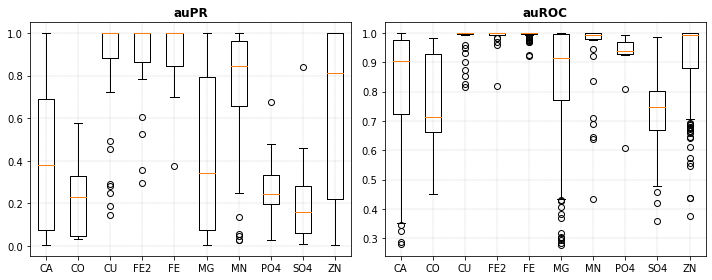

Analysing fold 4...


100%|██████████| 1121/1121 [00:11<00:00, 96.57it/s] 


ion, aupr, auroc
CA 0.428 0.83
CO 0.248 0.737
CU 0.855 0.973
FE2 0.783 0.981
FE 0.899 0.992
MG 0.422 0.856
MN 0.77 0.952
PO4 0.23 0.902
SO4 0.15 0.701
ZN 0.686 0.936


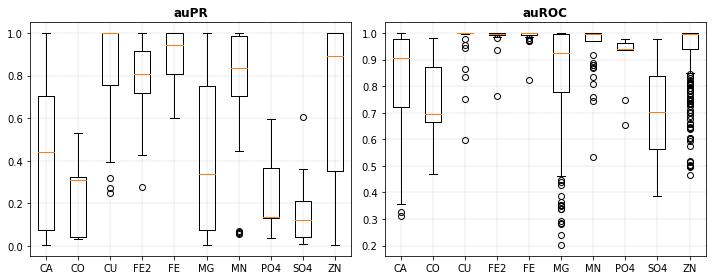

Analysing fold 5...


100%|██████████| 1121/1121 [00:11<00:00, 96.11it/s] 


ion, aupr, auroc
CA 0.409 0.838
CO 0.319 0.759
CU 0.798 0.97
FE2 0.856 0.993
FE 0.914 0.992
MG 0.415 0.836
MN 0.767 0.958
PO4 0.232 0.885
SO4 0.186 0.712
ZN 0.653 0.932


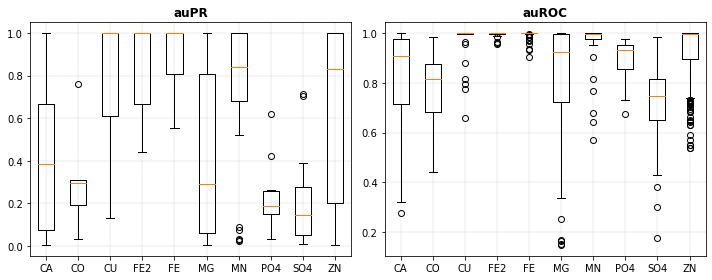

In [7]:
import torch
from models import IonicProtein
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torch.utils.data as data
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import collections

data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/'
model_name = 'esm1_t34_670M_UR50D'

for fold in range(1,6):
    print('Analysing fold %s...'%(fold))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trained_model = IonicProtein(dataloader_holdout.dataset[0][0].shape[1]).to(device)
    trained_model.load_state_dict(torch.load('checkpoints/%s_setB_fold%s.pt'%(model_name, fold)))
    trained_model.eval()

    count=0

    val_performance_dict = {'aupr':{k: [] for k in df['LigID'].unique()}, 
                            'auroc':{k: [] for k in df['LigID'].unique()},
                            'precision':{k: [] for k in df['LigID'].unique()},
                            'recall':{k: [] for k in df['LigID'].unique()},
                            'thresholds':{k: [] for k in df['LigID'].unique()}
                            }

    fields = list(collections.Counter(df['LigID']).keys())
    fields.append('null')
    label_dict = dict.fromkeys(fields, [])

    for pdbid in tqdm(df[df['partitions']==6]['pdb_chain'].values): # Run inference on partition 6
        emb = torch.load(model_name+'/'+pdbid+'.pt')
        key = list(emb['representations'].keys())
        emb = emb['representations'][key[0]]

        label_list = [int(a) for a in data_dict[pdbid][1]]
        label_dict = dict.fromkeys(fields, np.array([0]*len(emb)))
        label_dict[data_dict[pdbid][2]] = label_list
        null_label = np.ones(len(label_list))
        null_label[np.where(label_list==1)[0]]=0
        label_dict['null'] = null_label
        
        #print(emb.shape, len(label_dict))
        predictions = trained_model(emb.to(device), mask=None)

        for ion, i in zip(df['LigID'].unique(), range(len(df['LigID'].unique()))):
            if ion=='null':
                continue
            try:
                roc_auc = roc_auc_score(np.array(label_dict[ion]), predictions[i].cpu().data.numpy())
                fpr, tpr, threshold = roc_curve(np.array(label_dict[ion]), predictions[i].cpu().data.numpy())
                precision, recall, thresholds = precision_recall_curve(np.array(label_dict[ion]), predictions[i].cpu().data.numpy())
                aupr = average_precision_score(np.array(label_dict[ion]), predictions[i].cpu().data.numpy())
                val_performance_dict['aupr'][ion].append(aupr)
                val_performance_dict['auroc'][ion].append(roc_auc)
                val_performance_dict['precision'][ion].append(precision)
                val_performance_dict['recall'][ion].append(recall)
                val_performance_dict['thresholds'][ion].append(thresholds)

                #print(ion, 'aupr:', aupr, ', auroc:', roc_auc)
            except:
                pass

    # print statistics
    print('ion, aupr, auroc')
    for ion in df['LigID'].unique():
        print(ion, np.round(np.array(val_performance_dict['aupr'][ion]).mean(),3),
                   np.round(np.array(val_performance_dict['auroc'][ion]).mean(),3))

    # Plot model performances on holdout set
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].boxplot(val_performance_dict['aupr'].values())
    ax[0].set_xticklabels(val_performance_dict['aupr'].keys())
    ax[0].set_title('auPR', fontweight='bold')
    ax[0].grid(color='black', linestyle='-.', linewidth=0.1)
    #plt.show()

    #fig, ax = plt.subplots()
    ax[1].boxplot(val_performance_dict['auroc'].values())
    ax[1].set_xticklabels(val_performance_dict['auroc'].keys())
    ax[1].set_title('auROC', fontweight='bold')
    ax[1].grid(color='black', linestyle='-.', linewidth=0.1)

    plt.tight_layout()
    plt.show()
